In [1]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 9.4 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

# Embedding Model Comparison for RAG Systems

This notebook evaluates and compares different embedding models for Retrieval-Augmented Generation (RAG) systems. We analyze performance metrics like embedding generation time, query response time, and relevance of retrieved documents across different embedding models.

## Models Compared
- Llama 3.2 (4096 dimensions)
- Nomic Embed (768 dimensions)
- BGE-M3 (1024 dimensions)

## Process Overview
1. Load and preprocess documents
2. Configure embedding models
3. Run test queries
4. Evaluate and visualize performance metrics

In [2]:
# Install required dependencies
%pip install langchain langchain_community langchain_ollama langchain_text_splitters langchain_huggingface sentence-transformers pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Setup and Dependencies

Import all required libraries for document loading, text splitting, embedding generation, evaluation, and visualization.

In [3]:
# Import all necessary libraries
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

# Langchain imports
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_ollama import OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Configure plot settings
plt.rcParams.update({'font.size': 14})

## Document Loading and Processing

Load text documents from a directory and split them into smaller, context-specific chunks for embedding and retrieval.

In [4]:
# Load all text files from the specified directory
# folder_path = "C:/Users/LocalUser/Desktop/RAG_BOT/RAG_BOT/Embedding/sampledata"  # Change as needed
folder_path = "/content/sampledata"  # Change as needed
document_loader = DirectoryLoader(folder_path, glob="**/*.txt", loader_cls=TextLoader)
raw_documents = document_loader.load()

print(f"Number of documents loaded: {len(raw_documents)}")
print("Documents loaded:")
print(raw_documents)

Number of documents loaded: 1
Documents loaded:
[Document(metadata={'source': '/content/sampledata/ApplicationManagements.txt'}, page_content='ENDPOINT: Get application templates and categories\nPATH: /SaasManage/GetTemplatesAndCategories\nMETHOD: POST\nTAGS: Application Management\nMETADATA:\n  * x-idap-anon: False\nRESPONSES:\n  Status Code: 200\n  Description: API-Result\n  Content Type: */*\n  Response Schema: SaasManageGetTemplatesAndCategories\n  Response Body Properties:\n    * Result (object): A list of application templates\n      Nested properties:\n        * Category (string): Application category\n        * DisplayName (string): Application template display name\n        * AppType (string): Application type\n        * AppTypeDisplayName (string): Display name of application type\n        * Icon (string): Path of application icon image\n        * WebAppType (string): Application web-app-type\n        * Description (string): Application description\n        * Name (string): A

In [5]:
# Split each raw document based on dashed line and create sub-documents
split_documents = []
for doc in raw_documents:
    # Use regex to split based on dashed lines like '-----...'
    parts = re.split(r'-{5,}', doc.page_content)
    for i, part in enumerate(parts):
        cleaned_part = part.strip()
        if cleaned_part:
            split_documents.append(
                Document(
                    page_content=cleaned_part,
                    metadata={"source": doc.metadata["source"], "part": i + 1}
                )
            )

print(f"Total split chunks: {len(split_documents)}")

# Prepare documents with consistent metadata for embedding
documents = [
    Document(
        page_content=chunk.page_content,
        metadata=chunk.metadata
    ) for chunk in split_documents
]

Total split chunks: 35


## Embedding Models Configuration

Configure different embedding models with their respective dimensions for comparative evaluation.

In [34]:
# Set up embedding models with dimensions noted
embedding_models = {
    "HuggingFace": {
        "model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2"),
        "dimensions": 384
    },
    "Nomic": {
        "model": OllamaEmbeddings(model="nomic-embed-text:latest", base_url="http://localhost:11434"),
        "dimensions": 768
    },
    "BGE-M3": {
        "model": OllamaEmbeddings(model="bge-m3:567m", base_url="http://localhost:11434"),
        "dimensions": 1024
    }
}

### 1. Create FAISS Vector Stores for Each Model

In [9]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.5 MB/s eta 0:00:00


In [35]:
from langchain_community.vectorstores import FAISS
import time
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store vector stores
vector_stores = {}
embedding_times = {}

# Create vector stores for each model
for model_name, model_info in embedding_models.items():
    print(f"Creating vector store for {model_name}...")
    start_time = time.time()

    # Create vector store
    vector_store = FAISS.from_documents(
        documents,
        model_info["model"]
    )

    end_time = time.time()

    # Store vector store and embedding time
    vector_stores[model_name] = vector_store
    embedding_times[model_name] = end_time - start_time

    print(f"{model_name} - Embedding time: {embedding_times[model_name]:.2f} seconds")

Creating vector store for HuggingFace...
HuggingFace - Embedding time: 0.17 seconds
Creating vector store for Nomic...
Nomic - Embedding time: 1.04 seconds
Creating vector store for BGE-M3...
BGE-M3 - Embedding time: 2.45 seconds


### 2. Define Evaluation Metrics and Test Queries

In [36]:
# Define test queries relevant to API documentation
test_queries = [
    "How do I delete an application?",
    "What is the endpoint for getting policy block?",
    "How to authenticate API requests?",
    "How to import apps from templates?",
    "How to get TOTP codes for secured password?",
    "What parameters are required for updating application?"
]

# Function to evaluate retrieval performance
def evaluate_retrieval(vector_stores, queries, k=5):
    results = {}
    query_times = {}

    for model_name, vector_store in vector_stores.items():
        model_results = []
        model_query_times = []

        for query in queries:
            start_time = time.time()
            retrieved_docs = vector_store.similarity_search(query, k=k)
            end_time = time.time()

            query_time = end_time - start_time
            model_query_times.append(query_time)

            # Store results
            model_results.append({
                'query': query,
                'docs': retrieved_docs,
                'time': query_time
            })

        results[model_name] = model_results
        query_times[model_name] = model_query_times

    return results, query_times

### 3. Perform Evaluation and Collect Metrics

In [37]:
# Evaluate models
k_values = [3, 5, 10]
evaluation_results = {}
query_time_results = {}

for k in k_values:
    print(f"\nEvaluating with k={k}:")
    results, query_times = evaluate_retrieval(vector_stores, test_queries, k=k)
    evaluation_results[k] = results
    query_time_results[k] = query_times

    # Print average query times
    for model_name, times in query_times.items():
        avg_time = sum(times) / len(times)
        print(f"{model_name} - Avg query time: {avg_time:.4f} seconds")


Evaluating with k=3:
HuggingFace - Avg query time: 0.0074 seconds
Nomic - Avg query time: 0.0234 seconds
BGE-M3 - Avg query time: 0.1124 seconds

Evaluating with k=5:
HuggingFace - Avg query time: 0.0067 seconds
Nomic - Avg query time: 0.0231 seconds
BGE-M3 - Avg query time: 0.1159 seconds

Evaluating with k=10:
HuggingFace - Avg query time: 0.0069 seconds
Nomic - Avg query time: 0.0239 seconds
BGE-M3 - Avg query time: 0.1104 seconds


### 4. Relevance Scoring Function

In [38]:
def score_relevance(results, queries):
    """
    Manually score relevance of retrieved documents on a scale of 0-3
    0: Not relevant
    1: Somewhat relevant
    2: Relevant
    3: Highly relevant
    """
    relevance_scores = {}

    for model_name, model_results in results.items():
        model_scores = []

        for i, result in enumerate(model_results):
            query = queries[i]
            docs = result['docs']

            # Example of automated relevance scoring based on keyword matching
            # In a real scenario, you might want to manually review or use more sophisticated methods
            query_terms = set(query.lower().split())

            doc_scores = []
            for doc in docs:
                content = doc.page_content.lower()

                # Check if content contains API endpoint information related to query
                score = 0
                matched_terms = 0

                for term in query_terms:
                    if term in content:
                        matched_terms += 1

                # Calculate score based on term matches and presence of relevant API patterns
                term_ratio = matched_terms / len(query_terms) if query_terms else 0

                if term_ratio > 0.7 or (
                    ("endpoint" in content or "path" in content) and term_ratio > 0.3):
                    score = 3  # Highly relevant
                elif term_ratio > 0.5 or (
                    ("method" in content or "parameters" in content) and term_ratio > 0.2):
                    score = 2  # Relevant
                elif term_ratio > 0.3 or "tags" in content:
                    score = 1  # Somewhat relevant

                doc_scores.append(score)

            model_scores.append(doc_scores)

        relevance_scores[model_name] = model_scores

    return relevance_scores

### 5. Calculate NDCG Scores


In [39]:
def calculate_ndcg(relevance_scores, k=5):
    """Calculate NDCG scores for each model and query"""
    ndcg_scores = {}

    for model_name, model_scores in relevance_scores.items():
        model_ndcg = []

        for query_scores in model_scores:
            # Ensure we only use up to k scores
            scores = query_scores[:k]

            # Create ideal scores (sorted in descending order)
            ideal_scores = sorted(scores, reverse=True)

            # Calculate NDCG using scikit-learn
            if any(scores):  # Only calculate if there are any non-zero scores
                ndcg = ndcg_score(np.array([ideal_scores]), np.array([scores]))
                model_ndcg.append(ndcg)
            else:
                model_ndcg.append(0)

        ndcg_scores[model_name] = model_ndcg

    return ndcg_scores

### 6. Visualizations for Comparison


In [40]:
def visualize_results(embedding_times, query_times, ndcg_scores):
    """Create visualizations to compare models"""
    models = list(embedding_times.keys())

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot embedding times
    axes[0].bar(models, [embedding_times[model] for model in models])
    axes[0].set_title('Document Embedding Time (seconds)')
    axes[0].set_ylabel('Time (s)')
    axes[0].grid(axis='y', alpha=0.3)

    # Plot average query times
    # Access average query times directly from the query_times dictionary by model name
    avg_query_times = [np.mean(query_times[model]) for model in models]
    axes[1].bar(models, avg_query_times)
    axes[1].set_title('Average Query Time (seconds)')
    axes[1].set_ylabel('Time (s)')
    axes[1].grid(axis='y', alpha=0.3)

    # Plot average NDCG scores
    avg_ndcg = [np.mean(ndcg_scores[model]) for model in models]
    axes[2].bar(models, avg_ndcg)
    axes[2].set_title('Average NDCG Score')
    axes[2].set_ylabel('NDCG Score')
    axes[2].set_ylim(0, 1)
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create additional plot for dimension comparison
    dimensions = [embedding_models[model]["dimensions"] for model in models]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, dimensions)
    ax.set_title('Embedding Dimensions by Model')
    ax.set_ylabel('Dimensions')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

7. Run Evaluation and Display Results



Full evaluation with k=5:
HuggingFace - Avg NDCG: 0.9471
Nomic - Avg NDCG: 0.9184
BGE-M3 - Avg NDCG: 0.9152


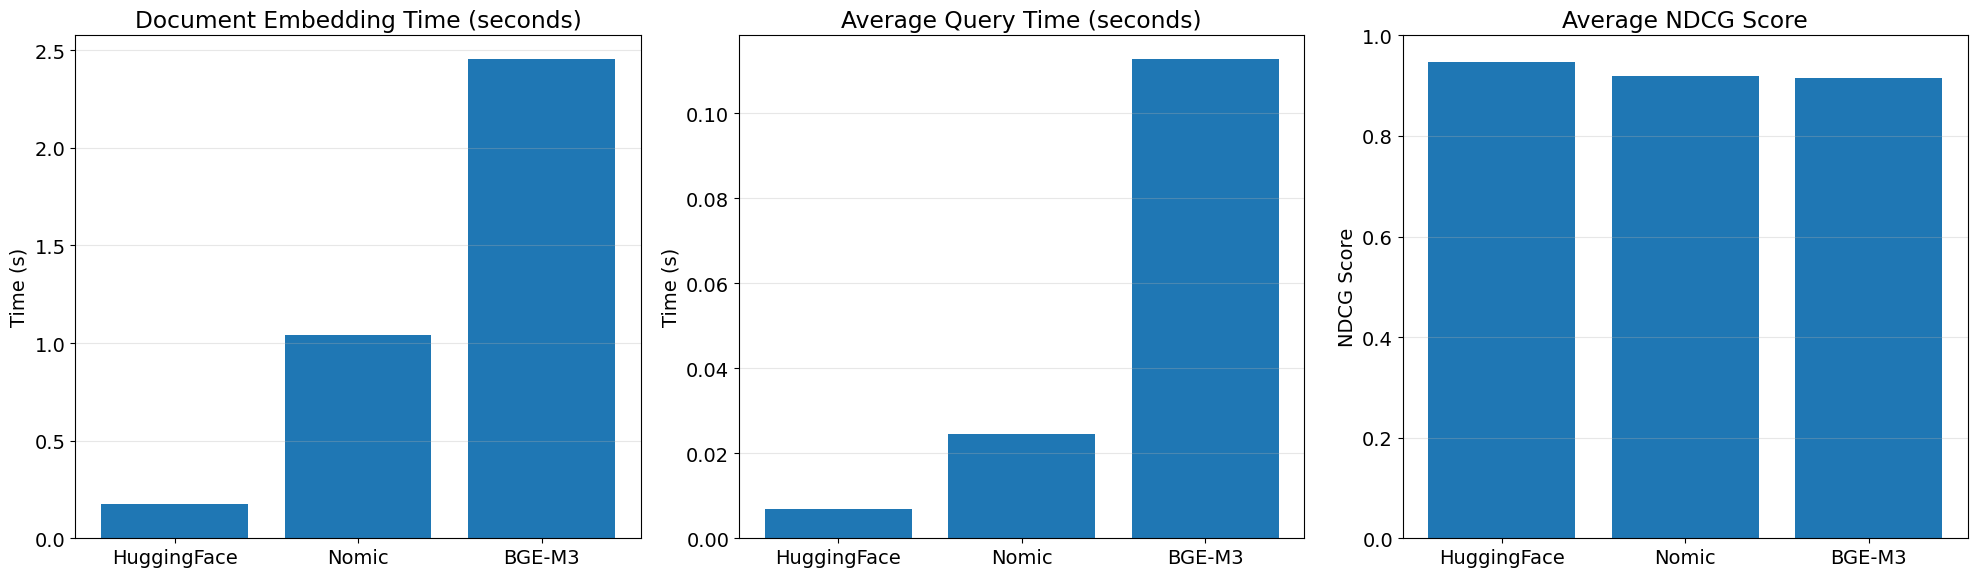

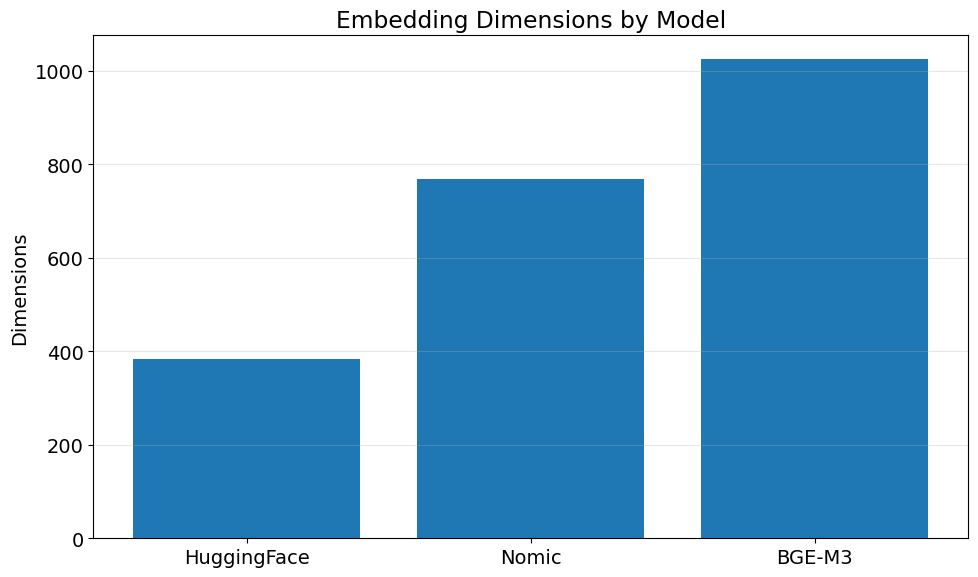

,Model,Embedding Time (s),Avg Query Time (s),Avg NDCG Score,Dimensions
0,HuggingFace,0.173643,0.006996,0.947085,384.0
1,Nomic,1.038672,0.024470,0.918382,768.0
2,BGE-M3,2.452950,0.112633,0.915217,1024.0


In [41]:
# Run the full evaluation
for k in [5]:  # You can try different k values
    print(f"\nFull evaluation with k={k}:")
    results, query_times = evaluate_retrieval(vector_stores, test_queries, k=k)

    # Score relevance
    relevance_scores = score_relevance(results, test_queries)

    # Calculate NDCG
    ndcg_scores = calculate_ndcg(relevance_scores, k)

    # Print average NDCG scores
    for model_name, scores in ndcg_scores.items():
        avg_ndcg = sum(scores) / len(scores)
        print(f"{model_name} - Avg NDCG: {avg_ndcg:.4f}")

    # Visualize results
    visualize_results(embedding_times, query_times, ndcg_scores)

    # Create detailed report
    report_df = pd.DataFrame({
        'Model': [],
        'Embedding Time (s)': [],
        'Avg Query Time (s)': [],
        'Avg NDCG Score': [],
        'Dimensions': []
    })

    for model_name in embedding_models.keys():
        report_df = pd.concat([report_df, pd.DataFrame({
            'Model': [model_name],
            'Embedding Time (s)': [embedding_times[model_name]],
            'Avg Query Time (s)': [np.mean(query_times[model_name])],
            'Avg NDCG Score': [np.mean(ndcg_scores[model_name])],
            'Dimensions': [embedding_models[model_name]["dimensions"]]
        })], ignore_index=True)

    display(report_df)

### 8. Analyze API-Specific Performance


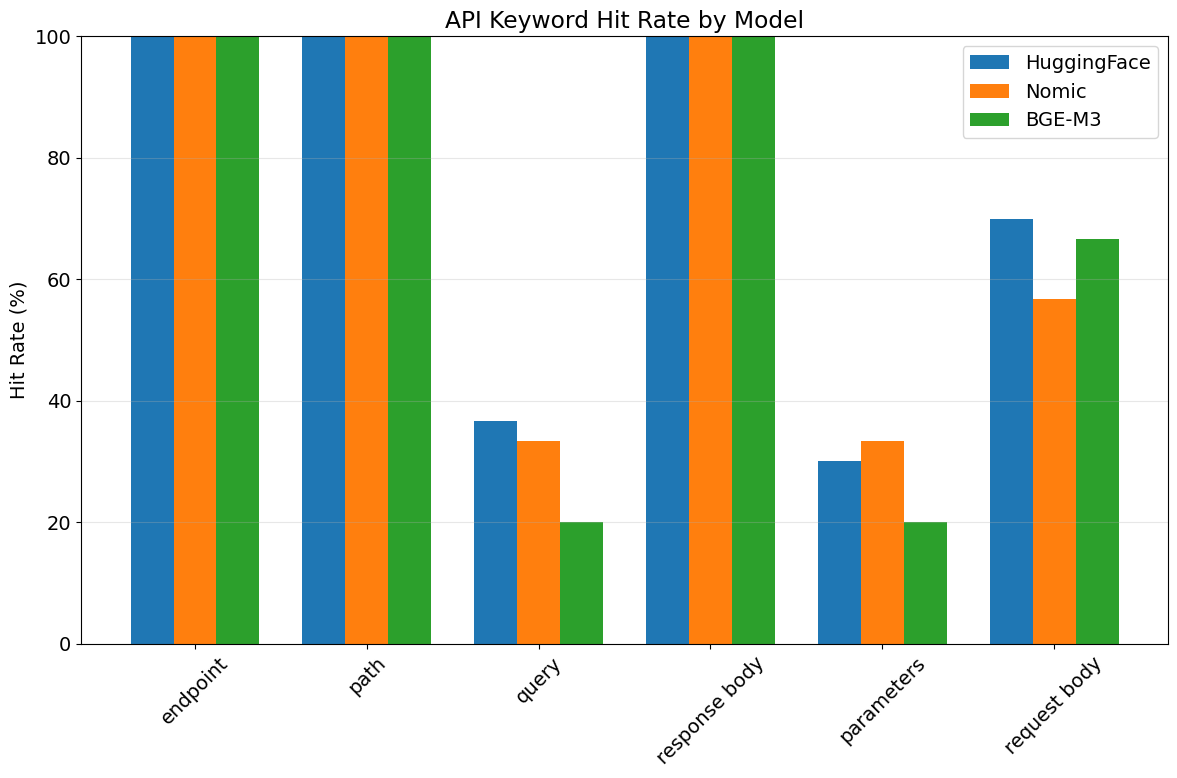

In [42]:
def analyze_api_retrieval(results, test_queries):
    """Analyze how well each model retrieves API-specific information"""
    api_keywords = ['endpoint', 'path', 'query', 'response body', 'parameters', 'request body']

    api_hit_rates = {}

    for model_name, model_results in results.items():
        keyword_hits = {keyword: 0 for keyword in api_keywords}
        total_docs = 0

        for i, result in enumerate(model_results):
            docs = result['docs']
            total_docs += len(docs)

            for doc in docs:
                content = doc.page_content.lower()
                for keyword in api_keywords:
                    if keyword in content:
                        keyword_hits[keyword] += 1

        # Calculate percentage of hits for each keyword
        for keyword in api_keywords:
            keyword_hits[keyword] = (keyword_hits[keyword] / total_docs) * 100

        api_hit_rates[model_name] = keyword_hits

    # Visualize API keyword hit rates
    models = list(api_hit_rates.keys())
    keywords = list(api_hit_rates[models[0]].keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(len(keywords))
    width = 0.25
    multiplier = 0

    for model_name in models:
        offset = width * multiplier
        rects = ax.bar(x + offset, [api_hit_rates[model_name][k] for k in keywords], width, label=model_name)
        multiplier += 1

    ax.set_title('API Keyword Hit Rate by Model')
    ax.set_xticks(x + width, keywords)
    ax.set_ylabel('Hit Rate (%)')
    ax.set_ylim(0, 100)
    ax.legend(loc='best')
    ax.grid(axis='y', alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return api_hit_rates

# Run API-specific analysis
api_hit_rates = analyze_api_retrieval(evaluation_results[5], test_queries)


    ## Model Recommendation

    Based on the evaluation metrics, the recommended embedding model is **HuggingFace**.
    
    ### Reasoning:
    - Embedding time: 0.17s (BGE-M3 has 2.45s)
    - Average query time: 0.0070s
    - NDCG score: 0.9471
    - Dimensions: 384
    
    This model provides the best balance between retrieval quality and performance for your API documentation use case.
    


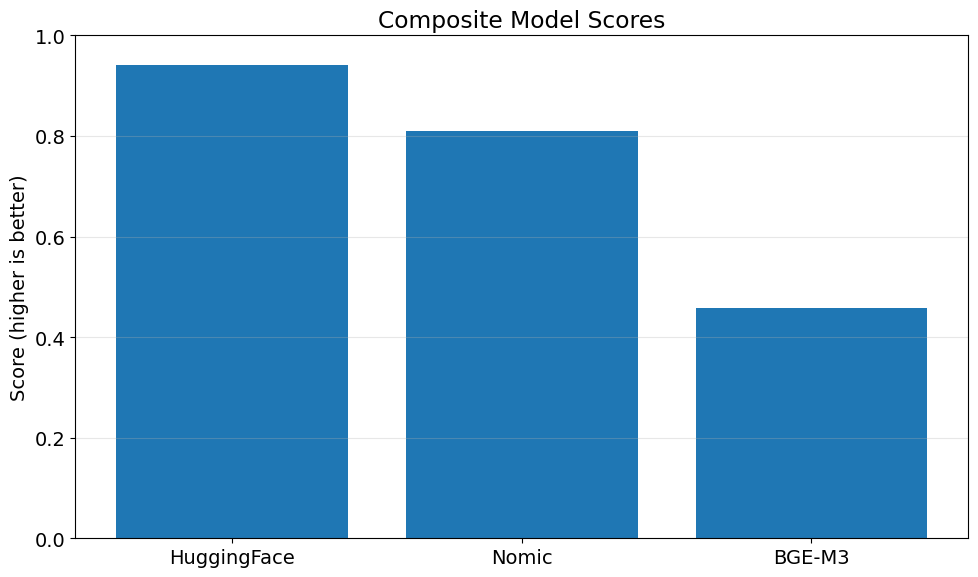

In [43]:
def recommend_best_model(embedding_times, query_times, ndcg_scores, dimensions):
    """Recommend the best model based on combined metrics"""
    models = list(embedding_times.keys())

    # Normalize metrics (lower is better for times, higher is better for NDCG)
    max_embed_time = max(embedding_times.values())
    max_query_time = max([np.mean(query_times[model]) for model in models])

    norm_embed_times = {model: 1 - (embedding_times[model] / max_embed_time) for model in models}
    norm_query_times = {model: 1 - (np.mean(query_times[model]) / max_query_time) for model in models}
    norm_ndcg = {model: np.mean(ndcg_scores[model]) for model in models}

    # Calculate composite score (equal weights for simplicity, adjust as needed)
    weights = {
        'embedding_time': 0.2,  # Less important for one-time operations
        'query_time': 0.3,      # Important for user experience
        'ndcg': 0.5            # Most important for retrieval quality
    }

    composite_scores = {}
    for model in models:
        score = (
            weights['embedding_time'] * norm_embed_times[model] +
            weights['query_time'] * norm_query_times[model] +
            weights['ndcg'] * norm_ndcg[model]
        )
        composite_scores[model] = score

    # Find best model
    best_model = max(composite_scores, key=composite_scores.get)

    # Create recommendation text
    recommendation = f"""
    ## Model Recommendation

    Based on the evaluation metrics, the recommended embedding model is **{best_model}**.

    ### Reasoning:
    - Embedding time: {embedding_times[best_model]:.2f}s ({max(embedding_models.items(), key=lambda x: x[1]['dimensions'])[0]} has {max_embed_time:.2f}s)
    - Average query time: {np.mean(query_times[best_model]):.4f}s
    - NDCG score: {np.mean(ndcg_scores[best_model]):.4f}
    - Dimensions: {embedding_models[best_model]['dimensions']}

    This model provides the best balance between retrieval quality and performance for your API documentation use case.
    """

    print(recommendation)

    # Plot composite scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, [composite_scores[model] for model in models])
    plt.title('Composite Model Scores')
    plt.ylabel('Score (higher is better)')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_model, composite_scores

# Generate recommendation
best_model, scores = recommend_best_model(
    embedding_times,
    query_times,
    ndcg_scores,
    {model: info["dimensions"] for model, info in embedding_models.items()}
)